In [1]:
import numpy as np
from astropy.io import fits 
from astropy.stats import sigma_clip
import pathlib
import os

def create_median_bias(bias_list, median_bias_filename):
    """Creates a median bias frame from a list of FITS bias files.

    Parameters:
    - bias_list: list of strings, paths to bias FITS files.
    - median_bias_filename: string, path to save the resulting median bias frame.

    Returns:
    - A 2D numpy array of the median bias frame.
    """
    # read all bias frames into a 3D numpy array (stack of 2D images)
    bias_frames = []
    for file in bias_list:
        data = fits.getdata(file).astype('f4')
        bias_frames.append(data)
        
    bias_stack = np.array(bias_frames)
    
    # apply sigma clipping along the stack axis (axis=0)
    clipping = sigma_clip(bias_stack, cenfunc = 'median', sigma=3.0, axis=0)
    

    # take the median of the clipped data
    # convert masked array to regular ndarray before saving
    median_bias = np.ma.median(clipping, axis=0)
    if isinstance(median_bias, np.ma.MaskedArray):
        median_bias = median_bias.filled()
    # returns fits immages 
    primary = fits.PrimaryHDU(data=median_bias, header=fits.Header())
    hdul = fits.HDUList([primary])
    hdul.writeto(median_bias_filename, overwrite=True)

    return median_bias

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# @Filename: darks.py
# @License: BSD 3-clause (http://www.opensource.org/licenses/BSD-3-Clause)


from astropy.io import fits
from astropy.stats import sigma_clip
import numpy as np

def create_median_dark(dark_list, bias_filename, median_dark_filename):
    """Creates a median dark frame corrected for bias and normalized by exposure time.

    Parameters:
    - dark_list: list of strings, paths to dark FITS files.
    - bias_filename: string, path to the median bias FITS file.
    - median_dark_filename: string, path to save the resulting median dark frame.

    Returns:
    - A 2D numpy array of the median dark frame.
    """

    # load the median bias frame
    bias_data = fits.getdata(bias_filename).astype('f4')

    # list to store bias-subtracted and normalized dark frames
    dark_corrected_frames = []

    for path in dark_list:
        with fits.open(path) as dark:
            dark_data = dark[0].data.astype('f4')
            exptime = dark[0].header['EXPTIME']
            if exptime <= 0:
                raise ValueError(f"Invalid EXPTIME ({exptime}) in {path}")
            dark_nobias = dark_data - bias_data
            dark_corrected_frames.append(dark_nobias / exptime)
            header = dark[0].header.copy()


    # stack and sigma clip the corrected dark frames
    dark_3d = np.array(dark_corrected_frames)
    clipping = sigma_clip(dark_3d, cenfunc = 'median', sigma=3.0, axis=0)

    # compute the median of the clipped data
    median_dark = np.ma.median(clipping, axis=0).filled()

    # save to a FITS file
    dark_hdu = fits.PrimaryHDU(data=median_dark, header=fits.Header())
    dark_hdu.writeto(median_dark_filename, overwrite=True)

    return median_dark


In [3]:
from astropy.io import fits
import numpy as np
import os
from collections import defaultdict

def create_median_flats_per_filter(flat_files, bias_file, dark_file=None, output_dir="."):
    """
    Create median flats grouped by filter.

    flat_files: list of flat FITS file paths
    bias_file: path to median bias FITS
    dark_file: optional median dark FITS path
    output_dir: where to save median flats
    
    Saves median flats named median_flat_<filter>.fits
    """
    # load bias and dark data once
    bias_data = fits.getdata(bias_file)
    dark_data = fits.getdata(dark_file) if dark_file else None
    
    # group flats by FILTER header
    flats_by_filter = defaultdict(list)
    for f in flat_files:
        with fits.open(f) as hdul:
            filter_name = hdul[0].header.get("FILTER", "UNKNOWN")
        flats_by_filter[filter_name].append(f)
    
    for filter_name, files in flats_by_filter.items():
        print(f"Processing {len(files)} flats for filter {filter_name}")
        calibrated_flats = []
        for fname in files:
            flat_data = fits.getdata(fname)
            # Bias subtract
            flat_corr = flat_data - bias_data
            # Dark subtract if available
            if dark_data is not None:
                flat_corr -= dark_data
            calibrated_flats.append(flat_corr)
        
        # stack and median combine
        stack = np.array(calibrated_flats)
        median_flat = np.median(stack, axis=0)
        
        # normalize
        median_val = np.median(median_flat)
        if median_val == 0:
            raise ValueError(f"Median of flat for filter {filter_name} is zero")
        median_flat /= median_val
        
        # save
        outname = os.path.join(output_dir, f"median_flat_{filter_name}.fits")
        fits.PrimaryHDU(data=median_flat).writeto(outname, overwrite=True)
        print(f"Saved median flat for filter {filter_name} to {outname}")



In [4]:
from astropy.io import fits
import numpy as np
from astropy.stats import sigma_clipped_stats
from photutils.detection import find_peaks
from photutils.segmentation import detect_sources
from scipy.ndimage import median_filter

def reduce_science_frame(
    science_filename,
    median_bias_filename,
    median_flat_filename,
    median_dark_filename,
    reduced_science_filename="reduced_science.fits",
):
    """Reduce a science frame using bias, dark, and flat frames."""

    # load all data
    with fits.open(science_filename) as hdul:
        science_header = hdul[0].header
        exposure_time = science_header.get('EXPTIME')
        science_data = fits.getdata(science_filename).astype('f4')

    bias_data = fits.getdata(median_bias_filename).astype('f4')
    dark_data = fits.getdata(median_dark_filename).astype('f4')
    flat_data = fits.getdata(median_flat_filename).astype('f4')
    

    # subtract bias
    reduced_science = science_data - bias_data

    # subtract dark (scaled by exposure time)
    reduced_science -= dark_data * exposure_time

    # flat field correction
    reduced_science /= flat_data

    # remove cosmic rays (simple median filter + threshold method)
    # this can be replaced with astroscrappy or similar for better accuracy
    smoothed = median_filter(reduced_science, size=3)
    residual = reduced_science - smoothed
    threshold = 5 * np.std(residual)
    mask = residual > threshold
    reduced_science[mask] = smoothed[mask]  # Replace cosmic rays

    # save to FITS
    primary_science = fits.PrimaryHDU(data=reduced_science.data, header=fits.Header())
    primary_science.writeto(reduced_science_filename, overwrite=True)

    return reduced_science


/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing 7 flats for filter H-Alpha
Saved median flat for filter H-Alpha to astr-480-env/work/arcsat_data/arcsat_code/scripts/data/median_flat_H-Alpha.fits
Processing 7 flats for filter g
Saved median flat for filter g to astr-480-env/work/arcsat_data/arcsat_code/scripts/data/median_flat_g.fits
Processing 7 flats for filter i
Saved median flat for filter i to astr-480-env/work/arcsat_data/arcsat_code/scripts/data/median_flat_i.fits
Processing 7 flats for filter r
Saved median flat for filter r to astr-480-env/work/arcsat_data/arcsat_code/scripts/data/median_flat_r.fits
Processing 7 flats for filter z
Saved median flat for filter z to astr-480-env/work/arcsat_data/arcsat_code/scripts/data/median_flat_z.fits


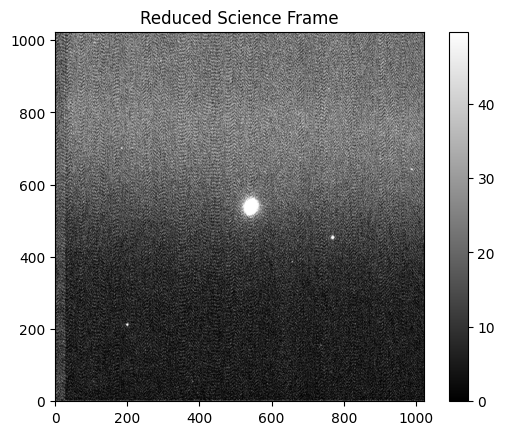

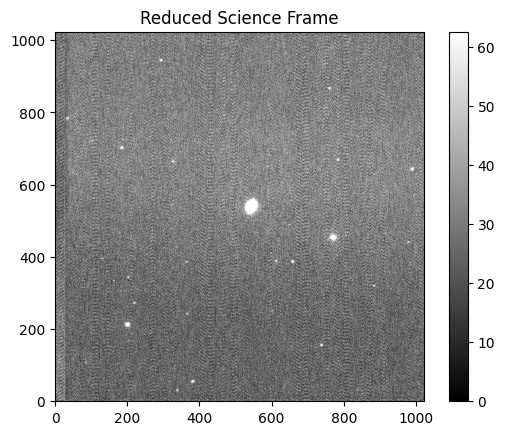

In [10]:

from pathlib import Path
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# define the data directory
data_dir = Path("astr-480-env/work/arcsat_data/arcsat_code/scripts/data")  # Adjust path depending on location of .fit files

# load and sort your calibration frames
bias_files = sorted([str(f) for f in data_dir.glob("Bias_*.fits")])
dark_files = sorted([str(f) for f in data_dir.glob("Dark_*.fits")])
flat_files = sorted([str(f) for f in data_dir.glob("domeflat_*.fits")])
sci_files = sorted([str(f) for f in data_dir.glob("Cats_*.fits")])
median_bias_file = data_dir / "median_bias.fits"
median_dark_file = data_dir / "median_dark.fits"

#implementing functions
create_median_bias(bias_files, str(data_dir / "median_bias.fits"))
create_median_dark(dark_files, str(data_dir / "median_bias.fits"), str(data_dir / "median_dark.fits"))
create_median_flats_per_filter(
    flat_files=flat_files,
    bias_file=str(median_bias_file),
    dark_file=str(median_dark_file),
    output_dir=str(data_dir)
)

#making sure the median flats and images are sorted in the same way 
median_flats = sorted(data_dir.glob("median_flat_*.fits"))
images = sorted(data_dir.glob("Cats_*.fits"))

# reduce science frame manually for each science frame 
reduce_science_frame(
    science_filename=sci_files[0],
    median_bias_filename=str(data_dir / "median_bias.fits"),
    median_dark_filename=str(data_dir / "median_dark.fits"),
    median_flat_filename=str(median_flats[0]),
    reduced_science_filename = str(data_dir / ("reduced_" + Path(sci_files[0]).name))
)

reduce_science_frame(
    science_filename=sci_files[1],
    median_bias_filename=str(data_dir / "median_bias.fits"),
    median_dark_filename=str(data_dir / "median_dark.fits"),
    median_flat_filename=str(median_flats[1]),
    reduced_science_filename = str(data_dir / ("reduced_" + Path(sci_files[1]).name))
)

reduce_science_frame(
    science_filename=sci_files[2],
    median_bias_filename=str(data_dir / "median_bias.fits"),
    median_dark_filename=str(data_dir / "median_dark.fits"),
    median_flat_filename=str(median_flats[2]),
    reduced_science_filename = str(data_dir / ("reduced_" + Path(sci_files[2]).name))
)

reduce_science_frame(
    science_filename=sci_files[3],
    median_bias_filename=str(data_dir / "median_bias.fits"),
    median_dark_filename=str(data_dir / "median_dark.fits"),
    median_flat_filename=str(median_flats[3]),
    reduced_science_filename = str(data_dir / ("reduced_" + Path(sci_files[3]).name))
)

reduce_science_frame(
    science_filename=sci_files[4],
    median_bias_filename=str(data_dir / "median_bias.fits"),
    median_dark_filename=str(data_dir / "median_dark.fits"),
    median_flat_filename=str(median_flats[4]),
    reduced_science_filename = str(data_dir / ("reduced_" + Path(sci_files[4]).name))
)


# show results (wanted to make sure it was running properly so I ran for H-Alpha and r filters
with fits.open(data_dir / f"reduced_{Path(sci_files[0]).name}") as hdul:
    plt.imshow(hdul[0].data, cmap='gray', origin='lower', vmin=0, vmax=np.percentile(hdul[0].data, 99))
    plt.title("Reduced Science Frame")
    plt.colorbar()
    plt.show()

with fits.open(data_dir / f"reduced_{Path(sci_files[3]).name}") as hdul:
    plt.imshow(hdul[0].data, cmap='gray', origin='lower', vmin=0, vmax=np.percentile(hdul[0].data, 99))
    plt.title("Reduced Science Frame")
    plt.colorbar()
    plt.show()


In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

#generating an RGB composite for nebula 
g_data = fits.getdata('astr-480-env/work/arcsat_data/scripts/data/reduced_Cats_Eye_Nebula_g_20250601_065904.fits')
r_data = fits.getdata('astr-480-env/work/arcsat_data/scripts/data/reduced_Cats_Eye_Nebula_r_20250601_065842.fits')
i_data = fits.getdata('astr-480-env/work/arcsat_data/scripts/data/reduced_Cats_Eye_Nebula_i_20250601_065929.fits')

def normalize(image, low=0.5, high=99.5):
    vmin, vmax = np.percentile(image, [low, high])
    norm = np.clip((image - vmin) / (vmax - vmin), 0, 1)
    return norm

R = normalize(i_data)  # i' as red
G = normalize(r_data)  # r' as green
B = normalize(g_data)  # g' as blue

rgb = np.dstack((R, G, B))

#plotting
plt.figure(figsize=(8, 8))
plt.imshow(rgb, origin='lower')
plt.axis('off')
plt.title('RGB Composite')
plt.savefig('RGB Composite')
plt.show()

In [ ]:
#reduced science image in r filter 

with fits.open(data_dir / f"reduced_{Path(sci_files[3]).name}") as hdul:
    plt.imshow(hdul[0].data, cmap='gray', origin='lower', vmin=0, vmax=np.percentile(hdul[0].data, 99))
    plt.title("Reduced Science Frame")
    plt.colorbar()
    plt.show()

In [ ]:
from astropy.io import fits
import numpy as np

def calculate_gain(files):
    """
    Calculate the detector gain (e-/ADU) using two flat-field images.

    Parameters:
        files (list): List of two flat-field FITS file paths.

    Returns:
        float: Calculated gain in e-/ADU.
    """
    if len(files) != 2:
        raise ValueError("You must provide exactly two flat-field images.")

    # Read the flat-field images
    flat1 = fits.getdata(files[0]).astype('f4')
    flat2 = fits.getdata(files[1]).astype('f4')

    # Calculate mean and variance
    mean1 = np.mean(flat1)
    mean2 = np.mean(flat2)
    mean_comb = (mean1 + mean2) / 2.0

    diff = flat1 - flat2
    variance_diff = np.var(diff) / 2.0  # Because var(A - B) = 2 * var(single image)

    gain = mean_comb / variance_diff

    return float(gain)

def calculate_readout_noise(files, gain):
    """
    Calculate the readout noise in electrons (e-) using two bias frames.

    Parameters:
        files (list): List of two bias FITS file paths.
        gain (float): Gain in e-/ADU.

    Returns:
        float: Readout noise in electrons.
    """
    if len(files) != 2:
        raise ValueError("You must provide exactly two bias frames.")

    # Read the bias frames
    bias1 = fits.getdata(files[0]).astype(np.float32)
    bias2 = fits.getdata(files[1]).astype(np.float32)

    # Calculate variance of the difference
    diff = bias1 - bias2
    variance_diff = np.var(diff) / 2.0  # Same reasoning as above

    readout_noise = np.sqrt(variance_diff) * gain

    return float(readout_noise)


In [ ]:
# calculating gain and readout noise 
flat_files = ["astr-480-env/work/arcsat_data/scripts/data/domeflat_g_001.fits","astr-480-env/work/arcsat_data/scripts/data/domeflat_g_002.fits"]
bias_files = ["astr-480-env/work/arcsat_data/scripts/data/Bias_BIN1_20250601_025309.fits", "astr-480-env/work/arcsat_data/scripts/data/Bias_BIN1_20250601_025324.fits"]

gain = calculate_gain(files = flat_files)
read_noise = calculate_readout_noise(files = bias_files, gain = gain)

print(f"Gain: {gain:.3f} e-/ADU")
print(f"Readout Noise: {read_noise:.2f} e-")
